In [1]:
import os
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import joblib


splits/           train_vectors.npy  val_vectors.npy
train_labels.npy  val_labels.npy     vectors/


In [9]:
X_train = np.load("/content/drive/MyDrive/projects/wbc-cnn-knn-classifier/data/vectors/train_vectors.npy")
y_train = np.load("/content/drive/MyDrive/projects/wbc-cnn-knn-classifier/data/vectors/train_labels.npy")

X_val   = np.load("/content/drive/MyDrive/projects/wbc-cnn-knn-classifier/data/vectors/val_vectors.npy")
y_val   = np.load("/content/drive/MyDrive/projects/wbc-cnn-knn-classifier/data/vectors/val_labels.npy")

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape,   "y_val  :", y_val.shape)



X_train: (8140, 1280) y_train: (8140,)
X_val  : (2035, 1280) y_val  : (2035,)


In [10]:
class_names = ['Basophil', 'Eosinophil', 'Lymphocyte', 'Monocyte', 'Neutrophil']


In [11]:
# We'll try with PCA dimensions; normalization
pca_dims_to_try = [None, 256, 128]

# K values to try
k_values = [1, 3, 5, 7, 9, 11, 15, 21]

# distance metrics worth trying on embeddings
metrics = ["euclidean", "cosine"]


In [13]:
best = {
    "val_acc": -1,
    "k": None,
    "metric": None,
    "pca_dim": None,
    "model": None
}

for pca_dim in pca_dims_to_try:
    for metric in metrics:
        for k in k_values:
            steps = [("scaler", StandardScaler())]

            if pca_dim is not None:
                steps.append(("pca", PCA(n_components=pca_dim, random_state=42)))

            steps.append(("knn", KNeighborsClassifier(n_neighbors=k, metric=metric)))
            pipe = Pipeline(steps)

            pipe.fit(X_train, y_train)
            preds = pipe.predict(X_val)
            acc = accuracy_score(y_val, preds)

            if acc > best["val_acc"]:
                best.update({
                    "val_acc": acc,
                    "k": k,
                    "metric": metric,
                    "pca_dim": pca_dim,
                    "model": pipe
                })

            print(f"PCA={pca_dim} metric={metric:9s} k={k:2d}  -> val_acc={acc:.4f}")

print("\n BEST CONFIG")
print(best)


<>:35: SyntaxWarning: invalid escape sequence '\ '
<>:35: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipython-input-3188981628.py:35: SyntaxWarning: invalid escape sequence '\ '
  print("\ BEST CONFIG")


PCA=None metric=euclidean k= 1  -> val_acc=0.9115
PCA=None metric=euclidean k= 3  -> val_acc=0.9238
PCA=None metric=euclidean k= 5  -> val_acc=0.9278
PCA=None metric=euclidean k= 7  -> val_acc=0.9322
PCA=None metric=euclidean k= 9  -> val_acc=0.9327
PCA=None metric=euclidean k=11  -> val_acc=0.9307
PCA=None metric=euclidean k=15  -> val_acc=0.9258
PCA=None metric=euclidean k=21  -> val_acc=0.9224
PCA=None metric=cosine    k= 1  -> val_acc=0.9174
PCA=None metric=cosine    k= 3  -> val_acc=0.9327
PCA=None metric=cosine    k= 5  -> val_acc=0.9346
PCA=None metric=cosine    k= 7  -> val_acc=0.9381
PCA=None metric=cosine    k= 9  -> val_acc=0.9445
PCA=None metric=cosine    k=11  -> val_acc=0.9425
PCA=None metric=cosine    k=15  -> val_acc=0.9430
PCA=None metric=cosine    k=21  -> val_acc=0.9420
PCA=256 metric=euclidean k= 1  -> val_acc=0.9125
PCA=256 metric=euclidean k= 3  -> val_acc=0.9292
PCA=256 metric=euclidean k= 5  -> val_acc=0.9351
PCA=256 metric=euclidean k= 7  -> val_acc=0.9351
PCA=

In [22]:
best_model = best["model"]
val_preds = best_model.predict(X_val)

print("Best val accuracy:", accuracy_score(y_val, val_preds))



Best val accuracy: 0.9444717444717444


In [18]:
cd ..

/content/drive/MyDrive/projects/wbc-cnn-knn-classifier


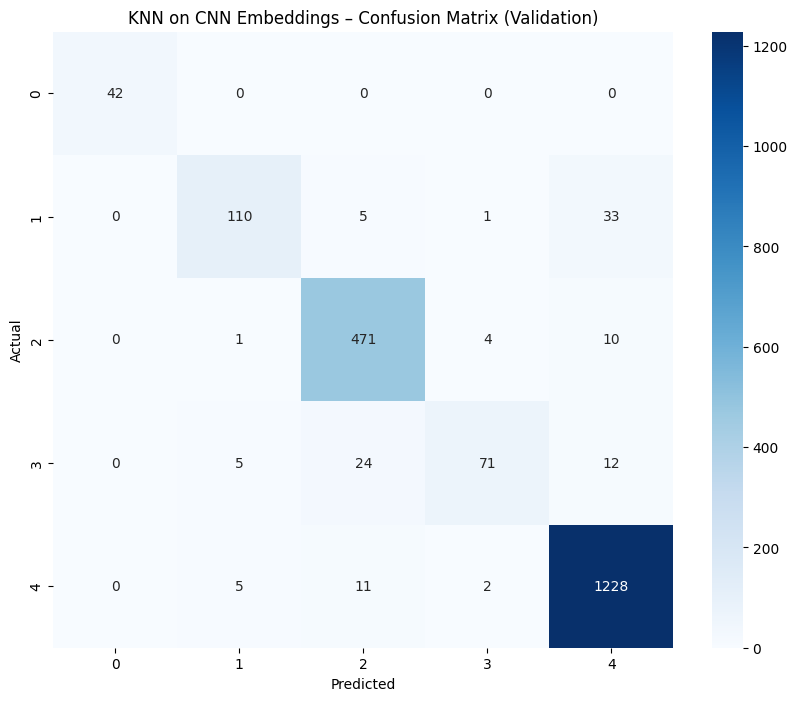

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       0.91      0.74      0.81       149
           2       0.92      0.97      0.94       486
           3       0.91      0.63      0.75       112
           4       0.96      0.99      0.97      1246

    accuracy                           0.94      2035
   macro avg       0.94      0.87      0.90      2035
weighted avg       0.94      0.94      0.94      2035



In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import os
os.makedirs("models/knn", exist_ok=True)

# Predictions on validation set
y_pred = best_model.predict(X_val)
y_true = y_val

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("KNN on CNN Embeddings – Confusion Matrix (Validation)")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.savefig("models/knn/confusion_matrix_val.png", dpi=300, bbox_inches="tight")
plt.show()

# Classification report
print(classification_report(y_true, y_pred))


In [23]:

save_path = "models/knn/knn_best.joblib"
joblib.dump(best_model, save_path)

print("Saved best KNN pipeline to:", save_path)
print("Config:", {"pca_dim": best["pca_dim"], "metric": best["metric"], "k": best["k"]})


Saved best KNN pipeline to: models/knn/knn_best.joblib
Config: {'pca_dim': None, 'metric': 'cosine', 'k': 9}


In [27]:
import numpy as np

# Predict probabilities
y_proba = best_model.predict_proba(X_val)

# Predicted class
y_pred = np.argmax(y_proba, axis=1)

# Confidence = max probability
y_confidence = np.max(y_proba, axis=1)

print("Example predictions:", y_pred[:10])
print("Example confidence :", y_confidence[:10])


Example predictions: [4 4 4 1 2 4 2 2 4 4]
Example confidence : [1.         1.         1.         1.         1.         1.
 0.44444444 1.         0.77777778 1.        ]
